In [1]:
# Main library: https://square.github.io/pysurvival/index.html
#----------------------------Reproducible------------------------------------------
import numpy as np
import random as rn
import pandas as pd
import os

seed=0
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
rn.seed(seed)

#----------------------------Reproducible------------------------------------------

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.model_selection import train_test_split
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from pysurvival.utils.display import display_loss_values
from pysurvival.utils.display import compare_to_actual

from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt

import heapq
import seaborn as sns

In [2]:
def csv_read(p_path):
    pd_data=pd.read_csv(p_path, sep=',')
    column_names=pd_data.columns.values.tolist()
    print(column_names)
    return pd_data,column_names

In [3]:
data,column_names=csv_read('./data/survival_data_filtered_3.csv')

['NACCREAS', 'NACCREFR', 'BIRTHMO', 'BIRTHYR', 'SEX', 'HISPANIC', 'HISPOR', 'RACE', 'RACESEC', 'RACETER', 'PRIMLANG', 'EDUC', 'MARISTAT', 'NACCLIVS', 'INDEPEND', 'RESIDENC', 'HANDED', 'NACCFADM', 'NACCFFTD', 'MEMORY', 'ORIENT', 'JUDGMENT', 'COMMUN', 'HOMEHOBB', 'PERSCARE', 'CDRSUM', 'DECSUB', 'DECIN', 'COGMEM', 'COGJUDG', 'COGLANG', 'COGVIS', 'COGATTN', 'COGOTHR', 'NACCCOGF', 'COGMODE', 'DECAGE', 'BEAPATHY', 'BEDEP', 'BEVHALL', 'BEAHALL', 'BEDEL', 'BEDISIN', 'BEIRRIT', 'BEAGIT', 'BEPERCH', 'BEOTHR', 'NACCBEHF', 'BEMODE', 'MOGAIT', 'MOFALLS', 'MOTREM', 'MOSLOW', 'NACCMOTF', 'MOMODE', 'COURSE', 'FRSTCHG', 'NORMCOG', 'DEMENTED', 'NACCPPA', 'NACCBVFT', 'NACCLBDS', 'NACCTMCI', 'NACCMCIL', 'NACCMCIA', 'NACCMCIE', 'NACCMCIV', 'NACCMCII', 'IMPNOMCI', 'NACCALZD', 'NACCALZP', 'NACCLBDE', 'NACCLBDP', 'PARK', 'PSP', 'PSPIF', 'CORT', 'CORTIF', 'DOWNS', 'DOWNSIF', 'HUNT', 'HUNTIF', 'PRION', 'PRIONIF', 'BRNINJ', 'BRNINJIF', 'HYCEPH', 'HYCEPHIF', 'NEOP', 'NEOPIF', 'DEP', 'DEPIF', 'OTHPSY', 'OTHPSYIF',

In [4]:
data

,NACCREAS,NACCREFR,BIRTHMO,BIRTHYR,SEX,HISPANIC,HISPOR,RACE,RACESEC,RACETER,...,NPBNKB,NACCFORM,NACCPARA,NACCCSFP,NPBNKF,NPFAUT,NACCDAGE,NACCINT,SurvivalTime,Event
0,1,2,4,1926,2,0,88,1,88,88,...,0,1,1,1,0,0,89,43,1787,True
1,1,8,3,1925,2,0,88,1,3,88,...,1,0,1,0,0,0,93,10,3659,False
2,2,2,12,1939,2,0,88,1,88,88,...,1,1,1,0,0,0,75,37,2151,False
3,2,2,4,1954,1,0,88,1,88,88,...,1,1,1,0,0,0,63,32,0,False
4,1,2,3,1963,1,0,88,1,88,88,...,1,1,1,0,0,0,53,10,490,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,2,2,4,1927,2,0,88,1,88,88,...,0,1,1,0,0,0,88,60,644,True
625,1,2,12,1948,2,0,88,1,88,88,...,1,0,1,0,0,0,67,4,0,False
626,1,1,3,1945,1,0,88,1,88,88,...,1,1,1,1,0,9,72,23,1238,False
627,2,2,7,1940,1,0,88,1,88,88,...,0,1,1,0,0,0,76,9,939,True


In [5]:
column_names

['NACCREAS',
 'NACCREFR',
 'BIRTHMO',
 'BIRTHYR',
 'SEX',
 'HISPANIC',
 'HISPOR',
 'RACE',
 'RACESEC',
 'RACETER',
 'PRIMLANG',
 'EDUC',
 'MARISTAT',
 'NACCLIVS',
 'INDEPEND',
 'RESIDENC',
 'HANDED',
 'NACCFADM',
 'NACCFFTD',
 'MEMORY',
 'ORIENT',
 'JUDGMENT',
 'COMMUN',
 'HOMEHOBB',
 'PERSCARE',
 'CDRSUM',
 'DECSUB',
 'DECIN',
 'COGMEM',
 'COGJUDG',
 'COGLANG',
 'COGVIS',
 'COGATTN',
 'COGOTHR',
 'NACCCOGF',
 'COGMODE',
 'DECAGE',
 'BEAPATHY',
 'BEDEP',
 'BEVHALL',
 'BEAHALL',
 'BEDEL',
 'BEDISIN',
 'BEIRRIT',
 'BEAGIT',
 'BEPERCH',
 'BEOTHR',
 'NACCBEHF',
 'BEMODE',
 'MOGAIT',
 'MOFALLS',
 'MOTREM',
 'MOSLOW',
 'NACCMOTF',
 'MOMODE',
 'COURSE',
 'FRSTCHG',
 'NORMCOG',
 'DEMENTED',
 'NACCPPA',
 'NACCBVFT',
 'NACCLBDS',
 'NACCTMCI',
 'NACCMCIL',
 'NACCMCIA',
 'NACCMCIE',
 'NACCMCIV',
 'NACCMCII',
 'IMPNOMCI',
 'NACCALZD',
 'NACCALZP',
 'NACCLBDE',
 'NACCLBDP',
 'PARK',
 'PSP',
 'PSPIF',
 'CORT',
 'CORTIF',
 'DOWNS',
 'DOWNSIF',
 'HUNT',
 'HUNTIF',
 'PRION',
 'PRIONIF',
 'BRNINJ',
 'BRN

In [6]:
Events=np.array(data.loc[:,'Event'])

In [7]:
print("%.2f%% samples are right censored in whole data." % (np.sum(~Events) * 100. / len(Events)))

59.94% samples are right censored in whole data.


% Completion: 100%|***********************************************|Loss: 732.95


C-index: 0.69


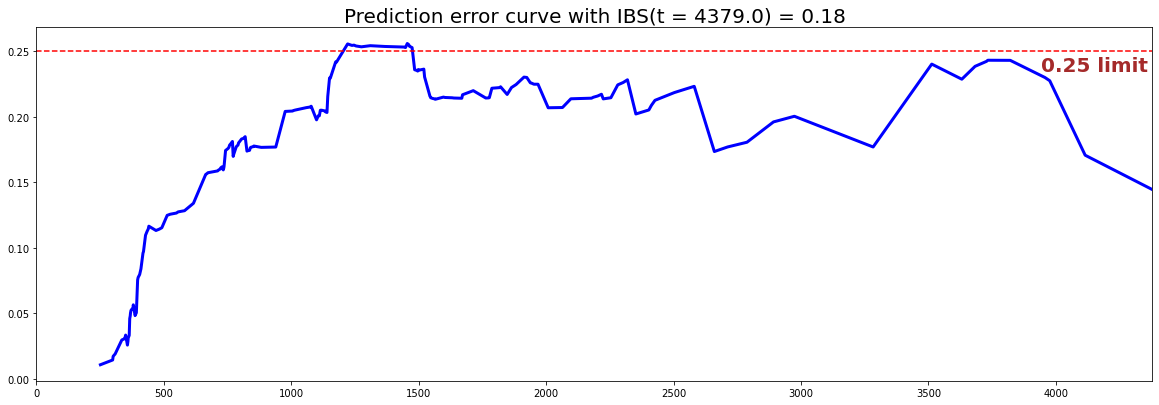

IBS: 0.18


In [8]:
X=data.loc[:,'NACCREAS':'NACCINT']
y_=data.loc[:,'SurvivalTime':'Event']
y=np.array([(y__[1],y__[0]) for y__ in np.array(y_)], dtype=[('Event', 'bool'), ('SurvivalTime', '<f8')])

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=0)

time_train=y_train['SurvivalTime']
event_train=y_train['Event']
time_test=y_test['SurvivalTime']
event_test=y_test['Event']

# Building the model
structure = [ {'activation': 'BentIdentity', 'num_units': 150}, ]
nonlinear_coxph = NonLinearCoxPHModel(structure=structure)
nonlinear_coxph.fit(X_train, time_train, event_train, num_epochs = 2000,lr=1e-4, init_method='glorot_uniform')

# Model Performances
c_index = concordance_index(nonlinear_coxph, X_test, time_test, event_test) #0.81
print('C-index: {:.2f}'.format(c_index))

ibs = integrated_brier_score(nonlinear_coxph, X_test, time_test, event_test, t_max=None, figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs))

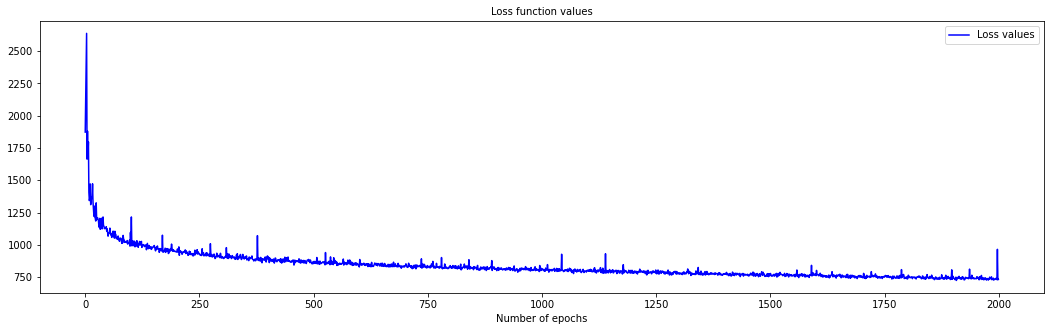

In [9]:
display_loss_values(nonlinear_coxph)

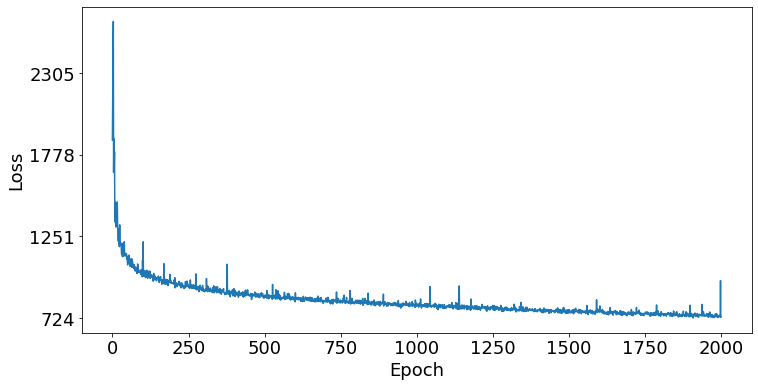

In [10]:
max_loss=int(np.max(nonlinear_coxph.loss_values))+1
min_loss=int(np.min(nonlinear_coxph.loss_values))

step=int(max_loss/5)

plt.figure(figsize=(12,6))
plt.plot(nonlinear_coxph.loss_values)
plt.xlabel('Epoch',fontsize=18)
plt.ylabel('Loss',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(np.arange(min_loss,max_loss,step),fontsize=18)
plt.show()

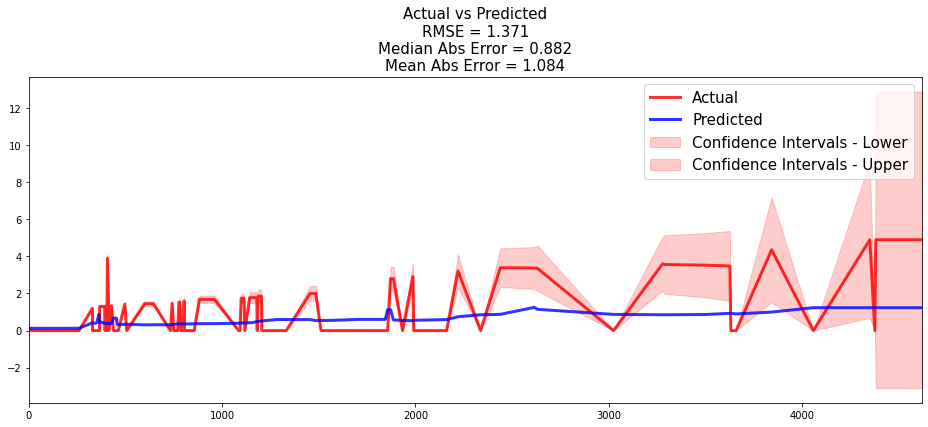

In [11]:
results = compare_to_actual(nonlinear_coxph, X_test, time_test, event_test,
                            is_at_risk = False,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])

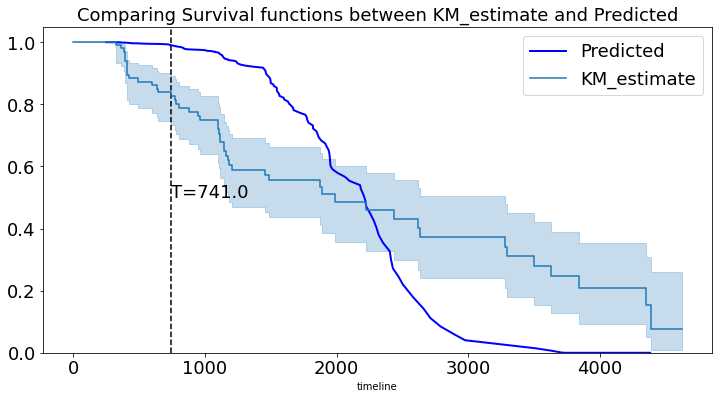

In [12]:
kmf = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(12, 6))

# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k = np.random.choice( choices, 1)[0]

# Saving the time of event
t = time_test[k]

# Computing the Survival function for all times t
predicted = nonlinear_coxph.predict_survival(X_test.values[k, :]).flatten()

# Displaying the functions
plt.plot(nonlinear_coxph.times, predicted, color='blue', label='Predicted', lw=2)

# Actual time
plt.axvline(x=t, color='black', ls ='--')
ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=18)

kmf.fit(time_test, event_observed=event_test)
ax = kmf.plot_survival_function(ax=ax)

# Show everything
title = "Comparing Survival functions between KM_estimate and Predicted"
plt.legend(fontsize=18)
plt.title(title, fontsize=18)
plt.ylim(0, 1.05)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

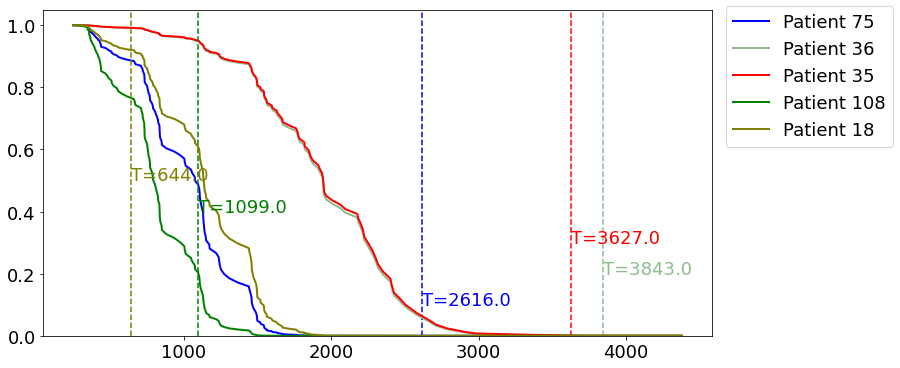

In [13]:
cs=['blue','darkseagreen','red','green','olive','cyan','tan','silver','purple','fuchsia','chocolate','darkcyan','aqua','pink','orange','bisque','lightsteelblue']

fig, ax = plt.subplots(figsize=(12, 6))

# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k_list = np.random.choice( choices, 5,replace=False)

# Saving the time of event
for i in np.arange(len(k_list)):
    k=k_list[i]
    t = time_test[k]

    # Computing the Survival function for all times t
    predicted = nonlinear_coxph.predict_survival(X_test.values[k, :]).flatten()

    # Displaying the functions
    plt.plot(nonlinear_coxph.times, predicted, color=cs[i], label='Patient '+str(k), lw=2)
    
    # Actual time
    plt.axvline(x=t, color=cs[i], ls ='--')
    ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, (0.1+i/10)), fontsize=18,color=cs[i])

plt.legend(loc=[1.02,0.58],fontsize=18, ncol=1)
plt.ylim(0, 1.05)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

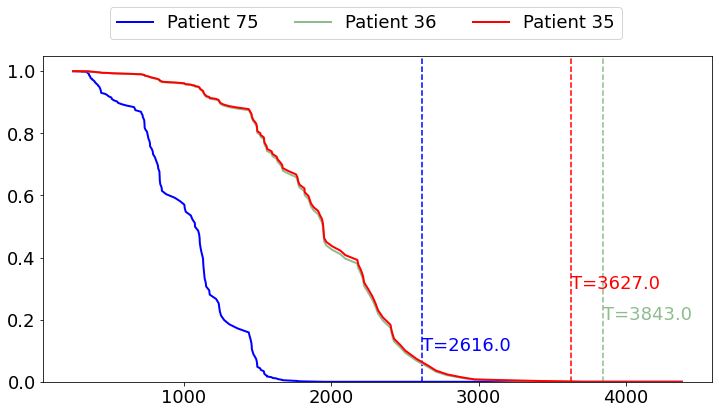

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))

# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k_list_ = k_list[0:3]

# Saving the time of event
for i in np.arange(len(k_list_)):
    k=k_list_[i]
    t = time_test[k]

    # Computing the Survival function for all times t
    predicted = nonlinear_coxph.predict_survival(X_test.values[k, :]).flatten()

    # Displaying the functions
    plt.plot(nonlinear_coxph.times, predicted, color=cs[i], label='Patient '+str(k), lw=2)
    
    # Actual time
    plt.axvline(x=t, color=cs[i], ls ='--')
    ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, (0.1+i/10)), fontsize=18,color=cs[i])

plt.legend(loc=[0.1,1.05],fontsize=18, ncol=3)
plt.ylim(0, 1.05)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [15]:
nonlinear_coxph.model

NeuralNet(
  (model): Sequential(
    (0): Linear(in_features=243, out_features=150, bias=True)
    (1): BentIdentity()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=150, out_features=1, bias=True)
  )
)

In [16]:
first_layer_weight=np.array(np.transpose(nonlinear_coxph.model.state_dict()['model.0.weight']))

In [17]:
feature_importace=np.linalg.norm(first_layer_weight,1, axis=1)

In [18]:
feature_importace

array([ 9.630444  ,  8.729055  ,  9.782059  ,  8.7837925 ,  9.279353  ,
        9.826385  ,  8.989629  ,  9.12354   ,  9.517859  ,  9.303136  ,
        9.135736  ,  8.314152  ,  9.471874  ,  9.483118  ,  9.172552  ,
        8.759071  ,  8.452605  ,  8.696833  ,  8.626695  , 10.100449  ,
        9.94995   ,  9.417266  ,  8.99267   ,  9.071901  , 10.144002  ,
        9.304782  ,  9.34553   ,  9.751959  ,  8.775949  ,  9.236092  ,
        9.556732  ,  9.559633  ,  9.764439  , 10.419186  , 10.7573395 ,
        9.812851  ,  8.951378  , 10.2576275 ,  8.736859  ,  9.227881  ,
        9.51111   ,  8.836015  ,  9.441269  ,  8.756098  ,  9.691168  ,
        8.792466  ,  9.691123  , 10.219955  ,  9.556612  ,  9.827275  ,
        8.6453705 , 10.169482  ,  9.550118  ,  8.08218   ,  9.31435   ,
        9.615196  ,  9.423554  ,  8.968312  ,  9.350368  ,  8.474586  ,
        9.869079  ,  9.211557  ,  9.598837  ,  9.3393545 ,  9.271874  ,
        9.477463  ,  9.018918  ,  9.88216   ,  9.683453  ,  8.52

In [19]:
first_layer_weight.shape

(243, 150)

In [20]:
column_names

['NACCREAS',
 'NACCREFR',
 'BIRTHMO',
 'BIRTHYR',
 'SEX',
 'HISPANIC',
 'HISPOR',
 'RACE',
 'RACESEC',
 'RACETER',
 'PRIMLANG',
 'EDUC',
 'MARISTAT',
 'NACCLIVS',
 'INDEPEND',
 'RESIDENC',
 'HANDED',
 'NACCFADM',
 'NACCFFTD',
 'MEMORY',
 'ORIENT',
 'JUDGMENT',
 'COMMUN',
 'HOMEHOBB',
 'PERSCARE',
 'CDRSUM',
 'DECSUB',
 'DECIN',
 'COGMEM',
 'COGJUDG',
 'COGLANG',
 'COGVIS',
 'COGATTN',
 'COGOTHR',
 'NACCCOGF',
 'COGMODE',
 'DECAGE',
 'BEAPATHY',
 'BEDEP',
 'BEVHALL',
 'BEAHALL',
 'BEDEL',
 'BEDISIN',
 'BEIRRIT',
 'BEAGIT',
 'BEPERCH',
 'BEOTHR',
 'NACCBEHF',
 'BEMODE',
 'MOGAIT',
 'MOFALLS',
 'MOTREM',
 'MOSLOW',
 'NACCMOTF',
 'MOMODE',
 'COURSE',
 'FRSTCHG',
 'NORMCOG',
 'DEMENTED',
 'NACCPPA',
 'NACCBVFT',
 'NACCLBDS',
 'NACCTMCI',
 'NACCMCIL',
 'NACCMCIA',
 'NACCMCIE',
 'NACCMCIV',
 'NACCMCII',
 'IMPNOMCI',
 'NACCALZD',
 'NACCALZP',
 'NACCLBDE',
 'NACCLBDP',
 'PARK',
 'PSP',
 'PSPIF',
 'CORT',
 'CORTIF',
 'DOWNS',
 'DOWNSIF',
 'HUNT',
 'HUNTIF',
 'PRION',
 'PRIONIF',
 'BRNINJ',
 'BRN

In [21]:
k=20
top_k=heapq.nlargest(k, range(len(feature_importace)), feature_importace.take)

In [22]:
top_k

[105,
 138,
 109,
 115,
 34,
 108,
 241,
 197,
 222,
 33,
 234,
 128,
 237,
 143,
 242,
 191,
 37,
 100,
 47,
 196]

In [23]:
feature_importace[top_k]

array([14.94556  , 12.066029 , 11.691751 , 10.757739 , 10.7573395,
       10.618322 , 10.610377 , 10.479424 , 10.423245 , 10.419186 ,
       10.370457 , 10.340877 , 10.33987  , 10.337116 , 10.324278 ,
       10.295608 , 10.2576275, 10.220743 , 10.219955 , 10.188497 ],
      dtype=float32)

In [24]:
np.array(column_names[:-2])[top_k]

array(['NACCAGEB', 'NACCVASC', 'NACCAGE', 'NPWBRWT', 'NACCCOGF',
       'NACCIDEM', 'NACCDAGE', 'NPFTDT5', 'NPPDXG', 'COGOTHR', 'NACCBNKF',
       'NPHISMB', 'NACCPARA', 'NPINF1D', 'NACCINT', 'NPHIPSCL',
       'BEAPATHY', 'COGOTH', 'NACCBEHF', 'NACCPROG'], dtype='<U8')

In [25]:
np.array(column_names[:-2]).shape

(243,)

In [26]:
first_layer_weight

array([[-0.0421361 , -0.07464609, -0.08287515, ..., -0.09670863,
         0.06164886,  0.03502035],
       [-0.05886527, -0.05276118,  0.07881849, ..., -0.06540292,
         0.08082964, -0.03783091],
       [-0.03673423, -0.02329932, -0.02781466, ...,  0.02043994,
        -0.03116012,  0.01420606],
       ...,
       [-0.00320219,  0.12048389,  0.111219  , ...,  0.06012125,
        -0.09715133,  0.09904376],
       [-0.04565679,  0.03196096, -0.0227952 , ..., -0.08024193,
         0.01080912, -0.0713902 ],
       [-0.10725286, -0.14872217, -0.13410415, ..., -0.11169072,
         0.07946535,  0.049726  ]], dtype=float32)

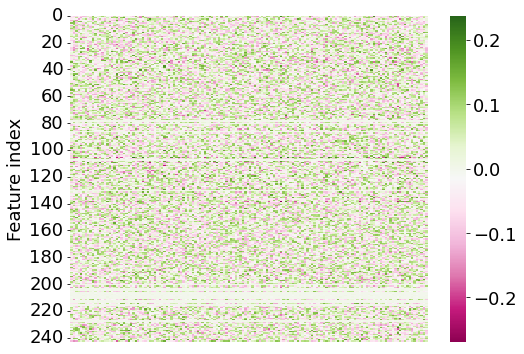

In [31]:
mn, mx = first_layer_weight.min(), first_layer_weight.max()

fig, ax = plt.subplots(figsize = (8,6))
heatmp=sns.heatmap(first_layer_weight, cmap='PiYG')
cbar = heatmp.collections[0].colorbar
# here set the labelsize by 18
cbar.ax.tick_params(labelsize=18)
plt.xlabel('')
plt.xticks([])
plt.yticks(np.arange(0,np.array(column_names[:-2]).shape[0],20),np.arange(0,np.array(column_names[:-2]).shape[0],20),fontsize=18)
plt.ylabel('Feature index',fontsize=18)
plt.show()

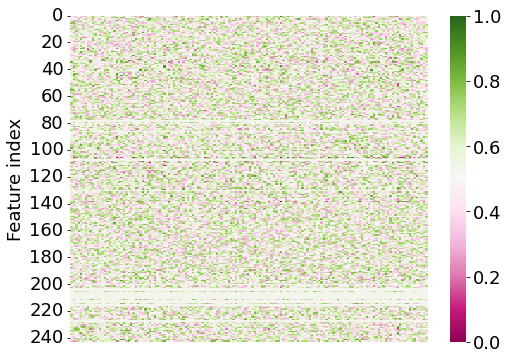

In [28]:
mn, mx = first_layer_weight.min(), first_layer_weight.max()
first_layer_weight_scaled = (first_layer_weight - mn) / (mx - mn)

fig, ax = plt.subplots(figsize = (8,6))
heatmp=sns.heatmap(first_layer_weight_scaled, cmap='PiYG', vmin=0, vmax=1)
cbar = heatmp.collections[0].colorbar
# here set the labelsize by 18
cbar.ax.tick_params(labelsize=18)
plt.xlabel('')
plt.xticks([])
plt.yticks(np.arange(0,np.array(column_names[:-2]).shape[0],20),np.arange(0,np.array(column_names[:-2]).shape[0],20),fontsize=18)
plt.ylabel('Feature index',fontsize=18)
plt.show()

In [30]:
len(nonlinear_coxph.loss_values)

2000